In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from pathlib import Path
import numpy as np
import multiprocessing
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# check if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Model

In [3]:
v = 2     # model version
in_c = 2  # number of input channels
num_c = 1 # number of classes to predict

In [4]:
# The optical flow input will look like this
# of = torch.randn(1,2,640,480)

In [5]:
model = EfficientNet.from_pretrained(f'efficientnet-b{v}', in_channels=in_c, num_classes=num_c)
model.to(device);

Loaded pretrained weights for efficientnet-b1


#### The output of the model will look like this

In [6]:
# of = of.to(device)
# model(of).item()

## Data

In [7]:
# directory with the optical flow images
of_dir = '../opical-flow-estimation-with-RAFT/output'
# labels as txt file
labels_f = 'train.txt'

In [8]:
class OFDataset(Dataset):
    def __init__(self, of_dir, label_f):
        self.len = len(list(Path(of_dir).glob('*.npy')))
        self.of_dir = of_dir
        self.label_file = open(label_f).readlines()
    def __len__(self): return self.len
    def __getitem__(self, idx):
        of_array = np.load(Path(self.of_dir)/f'{idx}.npy')
        of_tensor = torch.squeeze(torch.Tensor(of_array))
        label = float(self.label_file[idx].split()[0])
        return [of_tensor, label]

In [9]:
ds = OFDataset(of_dir, labels_f)

In [10]:
# 80% of data for training
# 20% of data for validation
train_split = .8

In [11]:
ds_size = len(ds)
indices = list(range(ds_size))
split = int(np.floor(train_split * ds_size))
train_idx, val_idx = indices[:split], indices[split:]

In [12]:
sample = ds[3]
assert type(sample[0]) == torch.Tensor
assert type(sample[1]) == float

In [13]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [14]:
cpu_cores = multiprocessing.cpu_count()
cpu_cores

8

In [15]:
train_dl = DataLoader(ds, batch_size=8, sampler=train_sampler, num_workers=0)
val_dl = DataLoader(ds, batch_size=8, sampler=val_sampler, num_workers=0)

In [16]:
def plot(train_loss,val_loss,title):
    N = len(train_loss)
    plt.plot(range(N),train_loss,label = 'train_loss')
    plt.plot(range(N),val_loss, label = 'val_loss')
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.legend()
    plt.savefig("./loss/result2.png")
    plt.show()

## Train

In [17]:
epochs = 25 
log_train_steps = 100

In [18]:
criterion = nn.MSELoss()
opt = optim.Adam(model.parameters())

In [19]:
history_train_loss = []
history_val_loss = []
best_loss = math.inf
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_losses = []
    for i, sample in enumerate(tqdm(train_dl)):
        of_tensor = sample[0].cuda()
        label = sample[1].float().cuda()
        opt.zero_grad()
        pred = torch.squeeze(model(of_tensor))
        loss = criterion(pred, label)
        train_losses.append(loss)
        loss.backward()
        opt.step()
    mean_train_loss = sum(train_losses)/len(train_losses)
    history_train_loss.append(mean_train_loss)
    print(f'{epoch}t: {mean_train_loss}')
    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for j, val_sample in enumerate(tqdm(val_dl)):
            of_tensor = val_sample[0].cuda()
            label = val_sample[1].float().cuda()
            pred = torch.squeeze(model(of_tensor))
            loss = criterion(pred, label)
            val_losses.append(loss)
        mean_val_loss = sum(val_losses)/len(val_losses)
        if(mean_val_loss < best_loss):
            torch.save(model.state_dict(), 'model/b1.pth')
            best_loss = mean_val_loss
        history_val_loss.append(mean_val_loss)
        print(f'{epoch}: {mean_val_loss}')

100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:24<00:00,  4.59it/s]


0t: 12.976804733276367


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.99it/s]


0: 6.851306915283203


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:29<00:00,  4.54it/s]


1t: 3.7360663414001465


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 18.20it/s]


1: 4.930903911590576


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:32<00:00,  4.50it/s]


2t: 2.7748935222625732


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 18.20it/s]


2: 2.720210313796997


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:32<00:00,  4.51it/s]


3t: 2.214627742767334


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:27<00:00, 18.25it/s]


3: 2.7055885791778564


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:30<00:00,  4.53it/s]


4t: 1.4465687274932861


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:27<00:00, 18.30it/s]


4: 4.618533134460449


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:28<00:00,  4.55it/s]


5t: 1.4713817834854126


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:27<00:00, 18.26it/s]


5: 2.8972339630126953


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:39<00:00,  4.44it/s]


6t: 1.4205888509750366


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.72it/s]


6: 3.835162878036499


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:47<00:00,  4.37it/s]


7t: 0.9960623979568481


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.79it/s]


7: 22.37958335876465


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:40<00:00,  4.43it/s]


8t: 0.9988795518875122


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:27<00:00, 18.34it/s]


8: 2.7434139251708984


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:27<00:00,  4.56it/s]


9t: 0.9931934475898743


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:27<00:00, 18.28it/s]


9: 2.318952798843384


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:30<00:00,  4.52it/s]


10t: 0.6197962760925293


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 18.20it/s]


10: 2.41264009475708


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:32<00:00,  4.51it/s]


11t: 0.8025020956993103


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 18.17it/s]


11: 2.3076095581054688


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:42<00:00,  4.41it/s]


12t: 0.5325841903686523


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.82it/s]


12: 2.6490917205810547


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:43<00:00,  4.40it/s]


13t: 0.7253086566925049


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.87it/s]


13: 2.522852897644043


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:48<00:00,  4.36it/s]


14t: 0.4197022318840027


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.69it/s]


14: 2.654768943786621


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:48<00:00,  4.35it/s]


15t: 0.5960388779640198


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.70it/s]


15: 25.861099243164062


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:47<00:00,  4.37it/s]


16t: 0.4888565242290497


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.84it/s]


16: 3.071098804473877


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:38<00:00,  4.45it/s]


17t: 0.4841226637363434


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:27<00:00, 18.27it/s]


17: 3.220672845840454


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:31<00:00,  4.52it/s]


18t: 0.6180153489112854


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 18.17it/s]


18: 2.555806875228882


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:33<00:00,  4.49it/s]


19t: 0.3321618139743805


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 18.18it/s]


19: 2.6137428283691406


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:32<00:00,  4.51it/s]


20t: 0.561128556728363


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:27<00:00, 18.23it/s]


20: 4.649683952331543


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:29<00:00,  4.53it/s]


21t: 0.3190653920173645


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 18.19it/s]


21: 2.2273964881896973


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:39<00:00,  4.44it/s]


22t: 0.5430343151092529


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.62it/s]


22: 3.355543851852417


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:50<00:00,  4.33it/s]


23t: 0.2912255525588989


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.72it/s]


23: 2.5292067527770996


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [07:46<00:00,  4.37it/s]


24t: 0.2676524221897125


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:28<00:00, 17.86it/s]

24: 3.311296224594116


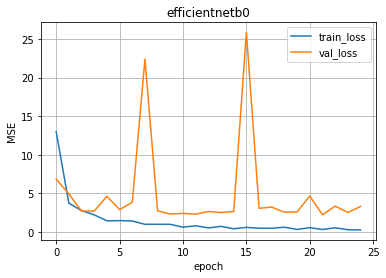

In [20]:
plot(history_train_loss,history_val_loss,"efficientnetb0")